In [1]:
# import necessary libraries
import pandas as pd
import pandas as pd
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
playerMatchDetailsPerformanceDF = pd.read_csv('../dataset/aggregateMatchAndTimeline.csv')
summonerRanksDF = pd.read_csv('../dataset/summonerRanks.csv')
summonerRanksDF = summonerRanksDF[['summonerId', 'queueType', 'tier', 'rank', 'leaguePoints']] # just selecting necessary sets of data

print(playerMatchDetailsPerformanceDF.shape)
print(summonerRanksDF.shape)

for aCol in playerMatchDetailsPerformanceDF.columns:
    print(aCol)

print("-------------------------------")
for rCol in summonerRanksDF.columns:
    print(rCol)

(607590, 29)
(279321, 5)
gameId
gameDuration
puuid
summonerId
teamId
win
teamPosition
champExperience
kills
assists
turretKills
epicMonsterKills
visionScore
visionWardsBoughtInGame
magicDamageDealtToChampions
deaths
totalMinionsKilled
timeCCingOthers
totalDamageTaken
totalHealsOnTeammates
totalTimeSpentDead
goldEarned
objectivesStolen
objectivesStolenAssists
participantId
participantsAssisted
towerKillsAssisted
monsterKillsAssisted
participantsAssistedWithPressure
-------------------------------
summonerId
queueType
tier
rank
leaguePoints


In [3]:
# join summonerRanks with aggregateMatchDF
playerMatchDetailsPerformanceWithRanksDF = playerMatchDetailsPerformanceDF.merge(summonerRanksDF, on='summonerId', how='inner')
print(playerMatchDetailsPerformanceWithRanksDF.shape)

# count of total players in each game; both teams; can be used for filtering matches or check sanity tests
matchPlayerCounts = playerMatchDetailsPerformanceWithRanksDF.groupby(['gameId'])['summonerId'].count().reset_index()
matchPlayerCounts.rename(columns={'summonerId': 'matchPlayerCounts'}, inplace=True)

# adds the matchPlayerCounts to the dataframe in use
playerMatchDetailsPerformanceWithRanksDF = playerMatchDetailsPerformanceWithRanksDF.merge(matchPlayerCounts, on='gameId', how='inner')
playerMatchDetailsPerformanceWithRanksDF.head()

# apply the filter of 10 players in a team to prevent cases of a single player being AFK
valid_player_match_details_df = playerMatchDetailsPerformanceWithRanksDF[playerMatchDetailsPerformanceWithRanksDF['matchPlayerCounts'] == 10]
print("Number of matches after player count filter: ", valid_player_match_details_df.shape[0] / 10) # divide by 10 because there are 10 rows for each match; corresponding to players

print("Number of unique players: ", valid_player_match_details_df['summonerId'].nunique())


(500002, 33)
Number of matches after player count filter:  31055.0
Number of unique players:  164571


In [4]:
valid_player_match_details_df[valid_player_match_details_df['gameId'] == 'EUW1_7140549083']

,gameId,gameDuration,puuid,summonerId,teamId,win,teamPosition,champExperience,kills,assists,...,participantId,participantsAssisted,towerKillsAssisted,monsterKillsAssisted,participantsAssistedWithPressure,queueType,tier,rank,leaguePoints,matchPlayerCounts
31,EUW1_7140549083,26.566667,xBmXs37yyo1423-Fd6XpsojD8Or17FekYcAxa1qq6-6dXc...,YBqGjstCR-41btzqIOKWbruFwbrJ5RlaRCtaw4Qxj7bNID...,100,0,TOP,11844,1,7,...,1,"[2, 3, 3, 3, 3, 3, 3]",[],[],"[2, 3]",RANKED_SOLO_5x5,DIAMOND,I,99,10
32,EUW1_7140549083,26.566667,Xujwtw0v2c7v-ChjLwWfq3J3Pln35tOK4U3obq4bhWXDCW...,rQLe27shxRSEU9svjDeJNdh69WBPyuh4HoOWHfTlrLgE9hBI,100,0,JUNGLE,10997,6,10,...,2,"[3, 3, 3, 3, 4, 4, 4, 4, 5, 5]",[],"[5, 7, 7]","[3, 3, 5]",RANKED_SOLO_5x5,MASTER,I,189,10
33,EUW1_7140549083,26.566667,o3Z7Wa9PmFxJJytiDOiTUNYmTMo2dVd01MnkQiV--h_1Do...,YcxYCCdSWw-fjx-xEMH9DGC6mR_P2A9pmEFzD5Za01oOj2eS,100,0,MIDDLE,13088,9,2,...,3,"[4, 5]",[],[5],[4],RANKED_SOLO_5x5,DIAMOND,II,46,10
34,EUW1_7140549083,26.566667,9Zg7jyJt3vME1rKYqJcry9KkWRgFswvJgu2jk0B_mvqmqG...,rp64bD0GBu_4f574wNyxNE-bfiuT4zwfYPZYzLKzFDUPNH...,100,0,BOTTOM,11608,9,6,...,4,"[2, 2, 3, 3, 5, 5]",[],[],"[2, 2, 2, 3, 5]",RANKED_SOLO_5x5,GRANDMASTER,I,448,10
35,EUW1_7140549083,26.566667,Jm6s1aooS3WmgrGGp2g03OTJRaxrXW-PKRs1fnpniZk0q_...,6QjTVyScEfTsw82HP-WcyE4aF_b04OEiYUYJY7uF8xugpqaw,100,0,UTILITY,7816,4,9,...,5,"[2, 2, 3, 3, 3, 4, 4, 4, 4]",[],[],"[2, 3]",RANKED_SOLO_5x5,GRANDMASTER,I,249,10
36,EUW1_7140549083,26.566667,3XS0N5Q0X_n-wypwRgyFBRQNli9pw0sVem2roPFiCqR4GM...,K8X74fpcAaymHpo2eTrH3H87W8EF3xDP-uqJfc7hNhwYYn...,200,1,TOP,16040,5,10,...,6,"[7, 7, 7, 7, 7, 8, 9, 9, 9, 10]",[],[],"[7, 7, 8, 8, 8, 9]",RANKED_SOLO_5x5,DIAMOND,II,12,10
37,EUW1_7140549083,26.566667,aUmT6ToECNUwESpSwoaTQl0ahZIq0Q-bOEYCukV7pwzECX...,MsYV2IuaSsFt3RGAJ5QR5ESdC7ocYa3rQzEAoRvgrPPpiD8,200,1,JUNGLE,15801,13,12,...,7,"[6, 6, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10]","[6, 8, 9]","[2, 9]","[8, 8, 9, 9, 9, 9, 10, 10, 10]",RANKED_SOLO_5x5,DIAMOND,III,86,10
38,EUW1_7140549083,26.566667,adSTuhAa-NjhG3bONSRTf_Wt15vD0UTKvnqusY1qv-r9iK...,8XPAKPBMBlj_zospjN58XVLfx_W9bpTxLiDzkX3nvcvqxV0,200,1,MIDDLE,15744,11,10,...,8,"[7, 7, 7, 9, 9, 9, 9, 10, 10, 10]","[6, 9, 9]",[7],"[7, 7, 9]",RANKED_SOLO_5x5,CHALLENGER,I,929,10
39,EUW1_7140549083,26.566667,fsqUiY9igT3v5TcSZiNe6pYj-dpNC4arWxrWB_nQQQ0zBY...,lvnseY8lvKgFSldgCQD52Sh64IBFTu-9nvPbSZDXBUrYdL...,200,1,BOTTOM,14892,17,13,...,9,"[6, 6, 7, 7, 7, 7, 7, 7, 8, 10, 10, 10, 10]","[6, 8]","[5, 7]","[7, 7, 8, 8]",RANKED_SOLO_5x5,DIAMOND,II,86,10
40,EUW1_7140549083,26.566667,5XprUOND5Yp3_bKAmFCwLD2GIzOb2YZyW0CSsPKOHPXBY5...,Hjt80nWvRiJagpmKOEJ1mUeMxjZn86L_uiRzA-PBL1OXmXM,200,1,UTILITY,9863,7,14,...,10,"[7, 7, 7, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9]",[],[7],"[6, 8, 8, 8, 9, 9, 9, 9]",RANKED_SOLO_5x5,DIAMOND,III,79,10


In [5]:
# of the 31055 player records (i.e. 31055 matches for 10 players in each team), the RECORDS for RANKED games should total to this number of 310550
valid_player_match_details_df['queueType'].value_counts()

## here 265853 + 44697 added to 310550. don't be confused that RANKED SOLO and RANKED FLEX always has to be multiple of 10. 
# it is possible that RANKED SOLO is being matched with opponent of RANKED FLEX 5


queueType
RANKED_SOLO_5x5    265853
RANKED_FLEX_SR      44697
Name: count, dtype: int64

In [6]:
summonerGamesPlayed = valid_player_match_details_df.groupby(['summonerId'])['gameId'].count().reset_index(name='summonerGamesPlayed')
valid_player_match_details_df = valid_player_match_details_df.merge(summonerGamesPlayed, on='summonerId', how='inner')
valid_player_match_details_df

,gameId,gameDuration,puuid,summonerId,teamId,win,teamPosition,champExperience,kills,assists,...,participantsAssisted,towerKillsAssisted,monsterKillsAssisted,participantsAssistedWithPressure,queueType,tier,rank,leaguePoints,matchPlayerCounts,summonerGamesPlayed
0,EUW1_7139824479,31.083333,VzT9MYU5ITMRfq2Mmn4pnI8HsgWAHFv8j09-_r6D-1TPmG...,urMqoBHLvge003_UlbDVtFxRI9hc1IUgDUHJibJyX7OPQHs,100,0,TOP,15998,3,10,...,"[2, 2, 2, 2, 3, 3, 3, 4, 4, 4]",[3],"[2, 4]","[3, 4]",RANKED_SOLO_5x5,IRON,I,49,10,1
1,EUW1_7139824479,31.083333,aWk9zdlyKGNhze_rQXc2xo-8rhQKaYy8PxfY-OAMlNNaBq...,IB17wcNnxvRxXv3ATJwo0BFBKl6funU0RU9f5Chg8wkm3sRu,100,0,JUNGLE,12801,5,12,...,"[1, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]",[4],[4],"[1, 1, 3, 5]",RANKED_FLEX_SR,IRON,I,49,10,1
2,EUW1_7139824479,31.083333,e9aN7zhCWdJVJgazZRIhI-2StvKMviVv_laUOyQPa55dXL...,6OSj8EMpeN-25RAzOVlkLoMss0qbRSDWt_DSV-EK9TbgAUFA,100,0,MIDDLE,16812,8,4,...,"[1, 2, 4, 4]",[4],"[2, 4]","[1, 2, 2, 2, 4, 4]",RANKED_FLEX_SR,IRON,II,51,10,1
3,EUW1_7139824479,31.083333,zKZam2yBLT_AG14bCDuppLyoOfn-cQuPCfkV7l1liB2N4N...,WL5b92v_8-lP1RvTKado4XL7ZnGnozfSHkOJyz6ruPhbaYIL,100,0,BOTTOM,13664,9,6,...,"[1, 2, 3, 3, 5, 5]",[],[],[2],RANKED_SOLO_5x5,BRONZE,IV,36,10,1
4,EUW1_7139824479,31.083333,jYGUTZOEAkCboL3kdTjS8R2Pey7M5AvLlEyJzpvToPbeQM...,7ik42UGLweXMslY7AHf4oJl2yIY7tJOHWfrQztibBg6D6aeq,100,0,UTILITY,9087,2,12,...,"[1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4]",[],[4],"[4, 4]",RANKED_SOLO_5x5,IRON,I,19,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310545,EUW1_7139963823,31.466667,UG0vKE0eAouHOWhChUdJB4Pdx79pfrhBS6lUHkvkJ1laU4...,q5_UPBn080NYn7ZSfiTK2_h9LS2Te-wdTYM1cWDSH5y6DG...,200,1,TOP,19157,9,5,...,"[7, 8, 8, 8, 9]",[7],[7],[],RANKED_SOLO_5x5,GRANDMASTER,I,338,10,42
310546,EUW1_7139963823,31.466667,k6KxICy3d9ac4K8H0GzhKmxJfQQsHvzGemoRMwG9PQFbN1...,If-qENegzmDli7cccZx9oEwQ_QaJb8TkVSg7srpkhh-fpUw,200,1,JUNGLE,13654,12,6,...,"[6, 8, 8, 9, 10, 10]",[],[],"[8, 9, 9]",RANKED_SOLO_5x5,GRANDMASTER,I,301,10,17
310547,EUW1_7139963823,31.466667,mDSydwZFZ8xmeZNfGLuofeWvtXQv6FAa9rv5n_clYVnCmf...,xOWK8rx58hgBl3zHaoerIsJOXvvIetUOLdBdYN0SlYd1CXqX,200,1,MIDDLE,15165,7,12,...,"[6, 6, 7, 7, 7, 7, 7, 7, 7, 9, 9, 10]","[6, 6, 7, 9]","[2, 2, 2, 7]","[7, 9]",RANKED_SOLO_5x5,MASTER,I,114,10,26
310548,EUW1_7139963823,31.466667,jdnPfIl3pCeVRdKem8oyFmyF6ByXwsHSTuF0eDEngmuUkX...,W07HWvdC3QYFl-L4p0hq9f9g3hxmdZwvuqi4ToIkvDBQBssm,200,1,BOTTOM,17052,4,14,...,"[6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 10]","[6, 6, 7]",[7],[8],RANKED_SOLO_5x5,CHALLENGER,I,649,10,51


In [7]:
# copy valid_player_match_details_df to filtered_valid_player_match_details_df
filtered_valid_player_match_details_df = valid_player_match_details_df

In [8]:
# convert player ranks to numerical ranks
# join the tier and rank to yield a combined value
filtered_valid_player_match_details_df['tierRank'] = filtered_valid_player_match_details_df['tier'] + '-' + filtered_valid_player_match_details_df['rank']

rankedDict = {
    'NA':0,
    'IRON-IV':1,
    'IRON-III':2,
    'IRON-II':3,
    'IRON-I':4,
    'BRONZE-IV':5,
    'BRONZE-III':6,
    'BRONZE-II':7,
    'BRONZE-I':8,
    'SILVER-IV':9,
    'SILVER-III':10,
    'SILVER-II':11,
    'SILVER-I':12,
    'GOLD-IV':13,
    'GOLD-III':14,
    'GOLD-II':15,
    'GOLD-I':16,
    'PLATINUM-IV':17,
    'PLATINUM-III':18,
    'PLATINUM-II':19,
    'PLATINUM-I':20,
    'EMERALD-IV':21,
    'EMERALD-III':22,
    'EMERALD-II':23,
    'EMERALD-I':24,
    'DIAMOND-IV':25,
    'DIAMOND-III':26,
    'DIAMOND-II':27,
    'DIAMOND-I':28,
    'MASTER-I':29,
    'GRANDMASTER-I':30,
    'CHALLENGER-I':31
}

# for calculating a numerical rank value for a player of a given match
def calculateNumericalRank(row):
    return rankedDict[row['tierRank']]

filtered_valid_player_match_details_df['playerNumericalRank'] = filtered_valid_player_match_details_df.apply(calculateNumericalRank, axis=1)

# averaging the rank of all 10 players in a match
matchAverageRankDF = filtered_valid_player_match_details_df.groupby(['gameId'])['playerNumericalRank'].mean().reset_index()
matchAverageRankDF.rename(columns={'playerNumericalRank': 'matchAverageRank'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(matchAverageRankDF, on='gameId', how='inner')

# averaging the rank of a given team in a match; 5 players in the team
teamAverageRankDF = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['playerNumericalRank'].mean().reset_index()
teamAverageRankDF.rename(columns={'playerNumericalRank': 'teamAverageRank'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(teamAverageRankDF, on=['gameId', 'teamId'], how='inner')

# summing up total goldEarned by a team in a match
totalTeamGold = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['goldEarned'].sum().reset_index()
totalTeamGold.rename(columns={'goldEarned': 'totalTeamGold'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(totalTeamGold, on=['gameId', 'teamId'], how='inner')

# another column for total gold per minute for the team
filtered_valid_player_match_details_df['totalTeamGPM'] = np.ceil(filtered_valid_player_match_details_df['totalTeamGold'] / filtered_valid_player_match_details_df['gameDuration'])

# summing up the total kills by a team in a match
totalTeamKills = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['kills'].sum().reset_index()
totalTeamKills.rename(columns={'kills': 'totalTeamKills'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(totalTeamKills, on=['gameId', 'teamId'], how='inner')

# another column for total kills per minute for the team
filtered_valid_player_match_details_df['totalTeamKPM'] = filtered_valid_player_match_details_df['totalTeamKills'] / filtered_valid_player_match_details_df['gameDuration']

# summing up the total deaths of a team in a match
totalTeamDeaths = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['deaths'].sum().reset_index()
totalTeamDeaths.rename(columns={'deaths': 'totalTeamDeaths'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(totalTeamDeaths, on=['gameId', 'teamId'], how='inner')

# summing up the total assists by a team in a match
totalTeamAssists = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['assists'].sum().reset_index()
totalTeamAssists.rename(columns={'assists': 'totalTeamAssists'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(totalTeamAssists, on=['gameId', 'teamId'], how='inner')

filtered_valid_player_match_details_df['totalTeamAPM'] = filtered_valid_player_match_details_df['totalTeamAssists'] / filtered_valid_player_match_details_df['gameDuration']

# summing up the total epicMonsterKills by a team in a match
totalTeamEpicMonsterKills = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['epicMonsterKills'].sum().reset_index()
totalTeamEpicMonsterKills.rename(columns={'epicMonsterKills': 'totalTeamEpicMonsterKills'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(totalTeamEpicMonsterKills, on=['gameId', 'teamId'], how='inner')

# summing up the total towers taken by a team in a match
totalTeamTowerKills = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['turretKills'].sum().reset_index()
totalTeamTowerKills.rename(columns={'turretKills': 'totalTeamTurretKills'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(totalTeamTowerKills, on=['gameId', 'teamId'], how='inner')

# summing up vision score for a team in a match
totalTeamVisionScore = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['visionScore'].sum().reset_index()
totalTeamVisionScore.rename(columns={'visionScore': 'totalTeamVisionScore'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(totalTeamVisionScore, on=['gameId', 'teamId'], how='inner')

# another metric for vision score of the team per minute
filtered_valid_player_match_details_df['totalTeamVPM'] = filtered_valid_player_match_details_df['totalTeamVisionScore'] / filtered_valid_player_match_details_df['gameDuration']

# team average vision score in a match
averageTeamVisionScore = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['visionScore'].mean().reset_index()
averageTeamVisionScore.rename(columns={'visionScore': 'averageTeamVisionScore'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(averageTeamVisionScore, on=['gameId', 'teamId'], how='inner')

# team total champ experience in a match
totalTeamChampExperience = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['champExperience'].sum().reset_index()
totalTeamChampExperience.rename(columns={'champExperience': 'totalTeamChampExperience'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(totalTeamChampExperience, on=['gameId', 'teamId'], how='inner')

# another column for total champ experience per minute per team
filtered_valid_player_match_details_df['totalTeamExpPerMin'] = filtered_valid_player_match_details_df['totalTeamChampExperience'] / filtered_valid_player_match_details_df['gameDuration']

# average champ experience per team
averageTeamChampExperience = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['champExperience'].mean().reset_index()
averageTeamChampExperience.rename(columns={'champExperience': 'averageTeamChampExperience'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(averageTeamChampExperience, on=['gameId', 'teamId'], how='inner')

# total minions killed by a team in a match
totalTeamMinionsKilled = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['totalMinionsKilled'].sum().reset_index()
totalTeamMinionsKilled.rename(columns={'totalMinionsKilled': 'totalTeamMinionsKilled'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(totalTeamMinionsKilled, on=['gameId', 'teamId'], how='inner')

filtered_valid_player_match_details_df['totalTeamMinionsPerMin'] = filtered_valid_player_match_details_df['totalTeamMinionsKilled'] / filtered_valid_player_match_details_df['gameDuration']

# average minions killed per team
averageTeamMinionsKilled = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['totalMinionsKilled'].mean().reset_index()
averageTeamMinionsKilled.rename(columns={'totalMinionsKilled': 'averageTeamMinionsKilled'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(averageTeamMinionsKilled, on=['gameId', 'teamId'], how='inner')

print(filtered_valid_player_match_details_df.shape)

filtered_valid_player_match_details_df[['gameId', 'teamId', 'win', 'participantId', 'teamPosition', 'kills', 'deaths', 'epicMonsterKills','assists', 'turretKills', 'playerNumericalRank', 'teamAverageRank', 'matchAverageRank', 'totalTeamKills', 'totalTeamDeaths', 'totalTeamAssists', 'totalTeamEpicMonsterKills', 'totalTeamTurretKills']].head(20)

(310550, 57)


,gameId,teamId,win,participantId,teamPosition,kills,deaths,epicMonsterKills,assists,turretKills,playerNumericalRank,teamAverageRank,matchAverageRank,totalTeamKills,totalTeamDeaths,totalTeamAssists,totalTeamEpicMonsterKills,totalTeamTurretKills
0,EUW1_7139824479,100,0,1,TOP,3,5,0,10,1,4,4.0,5.9,27,32,44,1,5
1,EUW1_7139824479,100,0,2,JUNGLE,5,9,0,12,0,4,4.0,5.9,27,32,44,1,5
2,EUW1_7139824479,100,0,3,MIDDLE,8,6,0,4,3,3,4.0,5.9,27,32,44,1,5
3,EUW1_7139824479,100,0,4,BOTTOM,9,5,1,6,1,5,4.0,5.9,27,32,44,1,5
4,EUW1_7139824479,100,0,5,UTILITY,2,7,0,12,0,4,4.0,5.9,27,32,44,1,5
5,EUW1_7139824479,200,1,6,TOP,12,4,0,7,4,11,7.8,5.9,32,27,45,3,8
6,EUW1_7139824479,200,1,7,JUNGLE,11,8,2,7,0,11,7.8,5.9,32,27,45,3,8
7,EUW1_7139824479,200,1,8,MIDDLE,5,8,0,6,0,6,7.8,5.9,32,27,45,3,8
8,EUW1_7139824479,200,1,9,BOTTOM,3,3,1,10,3,8,7.8,5.9,32,27,45,3,8
9,EUW1_7139824479,200,1,10,UTILITY,1,4,0,15,1,3,7.8,5.9,32,27,45,3,8


In [9]:
for col in valid_player_match_details_df.columns:
    print(col)

gameId
gameDuration
puuid
summonerId
teamId
win
teamPosition
champExperience
kills
assists
turretKills
epicMonsterKills
visionScore
visionWardsBoughtInGame
magicDamageDealtToChampions
deaths
totalMinionsKilled
timeCCingOthers
totalDamageTaken
totalHealsOnTeammates
totalTimeSpentDead
goldEarned
objectivesStolen
objectivesStolenAssists
participantId
participantsAssisted
towerKillsAssisted
monsterKillsAssisted
participantsAssistedWithPressure
queueType
tier
rank
leaguePoints
matchPlayerCounts
summonerGamesPlayed
tierRank
playerNumericalRank


In [10]:
filtered_valid_player_match_details_df['visionScore'].describe()

count    310550.000000
mean         30.363552
std          24.100312
min           0.000000
25%          15.000000
50%          22.000000
75%          35.000000
max         283.000000
Name: visionScore, dtype: float64

In [11]:
# convert the string representation of assists list into actual lists using ast
filtered_valid_player_match_details_df['participantsAssisted'] = filtered_valid_player_match_details_df['participantsAssisted'].apply(ast.literal_eval)
filtered_valid_player_match_details_df['towerKillsAssisted'] = filtered_valid_player_match_details_df['towerKillsAssisted'].apply(ast.literal_eval)
filtered_valid_player_match_details_df['monsterKillsAssisted'] = filtered_valid_player_match_details_df['monsterKillsAssisted'].apply(ast.literal_eval)
filtered_valid_player_match_details_df['participantsAssistedWithPressure'] = filtered_valid_player_match_details_df['participantsAssistedWithPressure'].apply(ast.literal_eval)

# concatenate the 4 lists into a single list
filtered_valid_player_match_details_df['totalAssisted'] = filtered_valid_player_match_details_df.apply(lambda row: [item for sublist in (row['participantsAssisted'], row['towerKillsAssisted'], row['monsterKillsAssisted'], row['participantsAssistedWithPressure']) for item in sublist], axis=1)

filtered_valid_player_match_details_df['assistsCount'] = filtered_valid_player_match_details_df['participantsAssisted'].apply(len)
filtered_valid_player_match_details_df['towerKillsAssistsCount'] = filtered_valid_player_match_details_df['towerKillsAssisted'].apply(len)
filtered_valid_player_match_details_df['monsterKillsAssistsCount'] = filtered_valid_player_match_details_df['monsterKillsAssisted'].apply(len)
filtered_valid_player_match_details_df['participantsAssistedWithPressureCount'] = filtered_valid_player_match_details_df['participantsAssistedWithPressure'].apply(len)
filtered_valid_player_match_details_df['allAssistsCount'] = filtered_valid_player_match_details_df['assistsCount'] + \
                                                            filtered_valid_player_match_details_df['towerKillsAssistsCount'] + \
                                                            filtered_valid_player_match_details_df['monsterKillsAssistsCount'] + \
                                                            filtered_valid_player_match_details_df['participantsAssistedWithPressureCount']

filtered_valid_player_match_details_df['allKills'] = filtered_valid_player_match_details_df['kills'] + filtered_valid_player_match_details_df['epicMonsterKills'] + filtered_valid_player_match_details_df['turretKills']

totalTeamAllKills = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['allKills'].sum().reset_index()
totalTeamAllKills.rename(columns={'allKills': 'totalTeamAllKills'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(totalTeamAllKills, on=['gameId', 'teamId'], how='inner')

totalTeamAllAssists = filtered_valid_player_match_details_df.groupby(['gameId', 'teamId'])['allAssistsCount'].sum().reset_index()
totalTeamAllAssists.rename(columns={'allAssistsCount': 'totalTeamAllAssists'}, inplace=True)
filtered_valid_player_match_details_df = filtered_valid_player_match_details_df.merge(totalTeamAllAssists, on=['gameId', 'teamId'], how='inner')


In [12]:
# create a sub-set of the dataframe from the valid matches that could be used to map assists
assistsMapDF = filtered_valid_player_match_details_df[[
    'gameId', 'teamId', 'win', 'teamPosition', 'teamAverageRank', 'matchAverageRank', # overall match info 
    'participantId', 'kills', 'deaths', 'assists', 'participantsAssisted', 'towerKillsAssisted', 'monsterKillsAssisted', 'participantsAssistedWithPressure', 'totalAssisted', # participant performance
    'totalTeamKills', 'totalTeamAssists', 'totalTeamTurretKills', 'totalTeamEpicMonsterKills', 'totalTeamAllKills', 'totalTeamAllAssists', # team performance
    'totalTeamGPM', 'totalTeamKPM', 'totalTeamExpPerMin', 'totalTeamVPM', 'totalTeamAPM', 'totalTeamMinionsPerMin' # per min team performance
]]

# # convert the string representation of assists list into actual lists using ast
# assistsMapDF['participantsAssisted'] = assistsMapDF['participantsAssisted'].apply(ast.literal_eval)
# assistsMapDF['towerKillsAssisted'] = assistsMapDF['towerKillsAssisted'].apply(ast.literal_eval)
# assistsMapDF['monsterKillsAssisted'] = assistsMapDF['monsterKillsAssisted'].apply(ast.literal_eval)
# assistsMapDF['participantsAssistedWithPressure'] = assistsMapDF['participantsAssistedWithPressure'].apply(ast.literal_eval)

# # concatenate the 4 lists into a single list
# assistsMapDF['totalAssisted'] = assistsMapDF.apply(lambda row: [item for sublist in (row['participantsAssisted'], row['towerKillsAssisted'], row['monsterKillsAssisted'], row['participantsAssistedWithPressure']) for item in sublist], axis=1)

# # new column to store the count of pressure assists per team
# totalTeamPressureAssists = assistsMapDF.groupby(['teamId', 'gameId'])['participantsAssistedWithPressure'].apply(lambda x: x.apply(len).sum()).reset_index()
# totalTeamPressureAssists.rename(columns={'participantsAssistedWithPressure': 'totalTeamPressureAssists'}, inplace=True)
# assistsMapDF = assistsMapDF.merge(totalTeamPressureAssists, on=['gameId', 'teamId'], how='inner')

# new column that sums up team assists of all kinds; used for normalization
# assistsMapDF['totalTeamAllAssists'] = assistsMapDF['totalTeamAssists'] + assistsMapDF['monsterKillsAssisted'] + assistsMapDF['towerKillsAssisted'] + assistsMapDF['totalTeamPressureAssists']
# assistsMapDF['totalTeamAllKills'] = assistsMapDF['totalTeamKills'] + assistsMapDF['totalTeamTurretKills'] + assistsMapDF['totalTeamEpicMonsterKills']
# assistsMapDF['intensity'] = assistsMapDF['totalTeamAllAssists'] / assistsMapDF['totalTeamAllKills']

assistsMapDF.head(20)

,gameId,teamId,win,teamPosition,teamAverageRank,matchAverageRank,participantId,kills,deaths,assists,...,totalTeamTurretKills,totalTeamEpicMonsterKills,totalTeamAllKills,totalTeamAllAssists,totalTeamGPM,totalTeamKPM,totalTeamExpPerMin,totalTeamVPM,totalTeamAPM,totalTeamMinionsPerMin
0,EUW1_7139824479,100,0,TOP,4.0,5.9,1,3,5,10,...,5,1,33,68,1836.0,0.868633,2199.313673,4.632708,1.415550,18.691689
1,EUW1_7139824479,100,0,JUNGLE,4.0,5.9,2,5,9,12,...,5,1,33,68,1836.0,0.868633,2199.313673,4.632708,1.415550,18.691689
2,EUW1_7139824479,100,0,MIDDLE,4.0,5.9,3,8,6,4,...,5,1,33,68,1836.0,0.868633,2199.313673,4.632708,1.415550,18.691689
3,EUW1_7139824479,100,0,BOTTOM,4.0,5.9,4,9,5,6,...,5,1,33,68,1836.0,0.868633,2199.313673,4.632708,1.415550,18.691689
4,EUW1_7139824479,100,0,UTILITY,4.0,5.9,5,2,7,12,...,5,1,33,68,1836.0,0.868633,2199.313673,4.632708,1.415550,18.691689
5,EUW1_7139824479,200,1,TOP,7.8,5.9,6,12,4,7,...,8,3,43,77,1939.0,1.029491,2255.292225,3.506702,1.447721,20.557641
6,EUW1_7139824479,200,1,JUNGLE,7.8,5.9,7,11,8,7,...,8,3,43,77,1939.0,1.029491,2255.292225,3.506702,1.447721,20.557641
7,EUW1_7139824479,200,1,MIDDLE,7.8,5.9,8,5,8,6,...,8,3,43,77,1939.0,1.029491,2255.292225,3.506702,1.447721,20.557641
8,EUW1_7139824479,200,1,BOTTOM,7.8,5.9,9,3,3,10,...,8,3,43,77,1939.0,1.029491,2255.292225,3.506702,1.447721,20.557641
9,EUW1_7139824479,200,1,UTILITY,7.8,5.9,10,1,4,15,...,8,3,43,77,1939.0,1.029491,2255.292225,3.506702,1.447721,20.557641


In [13]:
assistsMapDF['totalAssisted']

0             [2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 3, 2, 4, 3, 4]
1         [1, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 1, ...
2                   [1, 2, 4, 4, 4, 2, 4, 1, 2, 2, 2, 4, 4]
3                                     [1, 2, 3, 3, 5, 5, 2]
4             [1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4]
                                ...                        
310545                                [7, 8, 8, 8, 9, 7, 7]
310546                        [6, 8, 8, 9, 10, 10, 8, 9, 9]
310547    [6, 6, 7, 7, 7, 7, 7, 7, 7, 9, 9, 10, 6, 6, 7,...
310548    [6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 10, 6,...
310549    [6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 9, 9, 6, ...
Name: totalAssisted, Length: 310550, dtype: object

In [14]:
## based on the totalAssisted column, create another column that holds a dictionary such that (key,value) such that 
# key = participantId that was assisted and 
# value = number of times that participant was assisted

def convertListToDict(list):
    myDict = {}
    for item in list:
        if item not in myDict.keys():
            myDict[item] = 1
        else:
            myDict[item] += 1
    return myDict

assistsMapDF['totalAssistsMap'] = assistsMapDF['totalAssisted'].apply(convertListToDict)
assistsMapDF


/tmp/ipykernel_88189/3498873093.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assistsMapDF['totalAssistsMap'] = assistsMapDF['totalAssisted'].apply(convertListToDict)


,gameId,teamId,win,teamPosition,teamAverageRank,matchAverageRank,participantId,kills,deaths,assists,...,totalTeamEpicMonsterKills,totalTeamAllKills,totalTeamAllAssists,totalTeamGPM,totalTeamKPM,totalTeamExpPerMin,totalTeamVPM,totalTeamAPM,totalTeamMinionsPerMin,totalAssistsMap
0,EUW1_7139824479,100,0,TOP,4.0,5.9,1,3,5,10,...,1,33,68,1836.0,0.868633,2199.313673,4.632708,1.415550,18.691689,"{2: 5, 3: 5, 4: 5}"
1,EUW1_7139824479,100,0,JUNGLE,4.0,5.9,2,5,9,12,...,1,33,68,1836.0,0.868633,2199.313673,4.632708,1.415550,18.691689,"{1: 3, 3: 7, 4: 7, 5: 1}"
2,EUW1_7139824479,100,0,MIDDLE,4.0,5.9,3,8,6,4,...,1,33,68,1836.0,0.868633,2199.313673,4.632708,1.415550,18.691689,"{1: 2, 2: 5, 4: 6}"
3,EUW1_7139824479,100,0,BOTTOM,4.0,5.9,4,9,5,6,...,1,33,68,1836.0,0.868633,2199.313673,4.632708,1.415550,18.691689,"{1: 1, 2: 2, 3: 2, 5: 2}"
4,EUW1_7139824479,100,0,UTILITY,4.0,5.9,5,2,7,12,...,1,33,68,1836.0,0.868633,2199.313673,4.632708,1.415550,18.691689,"{1: 2, 2: 2, 3: 3, 4: 8}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310545,EUW1_7139963823,200,1,TOP,29.4,29.2,6,9,5,5,...,2,46,77,2105.0,1.080508,2418.177966,8.358051,1.620763,25.963983,"{7: 3, 8: 3, 9: 1}"
310546,EUW1_7139963823,200,1,JUNGLE,29.4,29.2,7,12,8,6,...,2,46,77,2105.0,1.080508,2418.177966,8.358051,1.620763,25.963983,"{6: 1, 8: 3, 9: 3, 10: 2}"
310547,EUW1_7139963823,200,1,MIDDLE,29.4,29.2,8,7,3,12,...,2,46,77,2105.0,1.080508,2418.177966,8.358051,1.620763,25.963983,"{6: 4, 7: 10, 9: 4, 10: 1, 2: 3}"
310548,EUW1_7139963823,200,1,BOTTOM,29.4,29.2,9,4,2,14,...,2,46,77,2105.0,1.080508,2418.177966,8.358051,1.620763,25.963983,"{6: 4, 7: 10, 8: 4, 10: 1}"


In [15]:
# computing total indegree and total outdegree of individual players in the team
from collections import defaultdict

# default empty dictionary to use later for indegree assignment
indegree = defaultdict(int)

# Calculate playerOutdegree and update indegree counts; alternatively you can use it to using len of totalAssisted
assistsMapDF['playerTotalOutdegree'] = assistsMapDF['totalAssistsMap'].apply(lambda x: sum(x.values()))

for _, row in assistsMapDF.iterrows():
    for teammate, assist_count in row['totalAssistsMap'].items():
        indegree[(row['gameId'], teammate)] += assist_count

# Add playerIndegree to the DataFrame
assistsMapDF['playerTotalIndegree'] = assistsMapDF.apply(lambda row: indegree[(row['gameId'], row['participantId'])], axis=1)

/tmp/ipykernel_88189/1315612252.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assistsMapDF['playerTotalOutdegree'] = assistsMapDF['totalAssistsMap'].apply(lambda x: sum(x.values()))
/tmp/ipykernel_88189/1315612252.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assistsMapDF['playerTotalIndegree'] = assistsMapDF.apply(lambda row: indegree[(row['gameId'], row['participantId'])], axis=1)


In [16]:
## computing in-degree centrality of a team
# step 1; compute max of team in-degree
teamMaxIndegree = assistsMapDF.groupby(['gameId', 'teamId'])['playerTotalIndegree'].max().reset_index()
teamMaxIndegree.rename(columns={'playerTotalIndegree': 'teamMaxIndegree'}, inplace=True)
assistsMapDF = assistsMapDF.merge(teamMaxIndegree, on=['gameId', 'teamId'], how='inner')

# step 2; compute sum of all team members in-degree
teamTotalIndegree = assistsMapDF.groupby(['gameId', 'teamId'])['playerTotalIndegree'].sum().reset_index()
teamTotalIndegree.rename(columns={'playerTotalIndegree': 'teamTotalIndegree'}, inplace=True)
assistsMapDF = assistsMapDF.merge(teamTotalIndegree, on=['gameId', 'teamId'], how='inner')

# step 3; sum up the difference between max and individual in-degree and sum it up to another column
assistsMapDF['playerDiffMaxTeamIndegree'] = assistsMapDF['teamMaxIndegree'] - assistsMapDF['playerTotalIndegree']
playerDiffMaxTeamIndegreeSum = assistsMapDF.groupby(['gameId', 'teamId'])['playerDiffMaxTeamIndegree'].sum().reset_index()
playerDiffMaxTeamIndegreeSum.rename(columns={'playerDiffMaxTeamIndegree': 'playerDiffMaxTeamIndegreeSum'}, inplace=True)
assistsMapDF = assistsMapDF.merge(playerDiffMaxTeamIndegreeSum, on=['gameId', 'teamId'], how='inner')

# step 4; the summed up column to be divided by (4 * sum of all indegrees)
assistsMapDF['teamIndegreeCentrality'] = assistsMapDF['playerDiffMaxTeamIndegreeSum'] / ( 4 * assistsMapDF['teamTotalIndegree'] )

In [17]:
## computing out-degree centrality of a team and weight centralization of the team
# step 1; compute max of team's out-degree
teamMaxOutdegree = assistsMapDF.groupby(['gameId', 'teamId'])['playerTotalOutdegree'].max().reset_index()
teamMaxOutdegree.rename(columns={'playerTotalOutdegree': 'teamMaxOutdegree'}, inplace=True)
assistsMapDF = assistsMapDF.merge(teamMaxOutdegree, on=['gameId', 'teamId'], how='inner')

# step 2; compute sum of all team members out-degree
teamTotalOutdegree = assistsMapDF.groupby(['gameId', 'teamId'])['playerTotalOutdegree'].sum().reset_index()
teamTotalOutdegree.rename(columns={'playerTotalOutdegree': 'teamTotalOutdegree'}, inplace=True)
assistsMapDF = assistsMapDF.merge(teamTotalOutdegree, on=['gameId', 'teamId'], how='inner')

# step 3; sum up the difference between max and individual out-degree and sum it up to another column
assistsMapDF['playerDiffMaxTeamOutdegree'] = assistsMapDF['teamMaxOutdegree'] - assistsMapDF['playerTotalOutdegree']
playerDiffMaxTeamIndegreeSum = assistsMapDF.groupby(['gameId', 'teamId'])['playerDiffMaxTeamOutdegree'].sum().reset_index()
playerDiffMaxTeamIndegreeSum.rename(columns={'playerDiffMaxTeamOutdegree': 'playerDiffMaxTeamOutdegreeSum'}, inplace=True)
assistsMapDF = assistsMapDF.merge(playerDiffMaxTeamIndegreeSum, on=['gameId', 'teamId'], how='inner')

# step 4; the summed up column to be divided by (4 * sum of all indegrees)
assistsMapDF['teamOutdegreeCentrality'] = assistsMapDF['playerDiffMaxTeamOutdegreeSum'] / ( 4 * assistsMapDF['teamTotalIndegree'] ) # 4 = N-1; totalTeamIndegree is the same as totalTeamOutdegree; so you can use either of them

# for weight centralization
assistsMapDF['teamWeightCentralization'] = assistsMapDF['playerDiffMaxTeamOutdegreeSum'] / (19 * assistsMapDF['teamTotalIndegree'])

assistsMapDF

,gameId,teamId,win,teamPosition,teamAverageRank,matchAverageRank,participantId,kills,deaths,assists,...,teamTotalIndegree,playerDiffMaxTeamIndegree,playerDiffMaxTeamIndegreeSum,teamIndegreeCentrality,teamMaxOutdegree,teamTotalOutdegree,playerDiffMaxTeamOutdegree,playerDiffMaxTeamOutdegreeSum,teamOutdegreeCentrality,teamWeightCentralization
0,EUW1_7139824479,100,0,TOP,4.0,5.9,1,3,5,10,...,68,18,62,0.227941,18,68,3,22,0.080882,0.017028
1,EUW1_7139824479,100,0,JUNGLE,4.0,5.9,2,5,9,12,...,68,12,62,0.227941,18,68,0,22,0.080882,0.017028
2,EUW1_7139824479,100,0,MIDDLE,4.0,5.9,3,8,6,4,...,68,9,62,0.227941,18,68,5,22,0.080882,0.017028
3,EUW1_7139824479,100,0,BOTTOM,4.0,5.9,4,9,5,6,...,68,0,62,0.227941,18,68,11,22,0.080882,0.017028
4,EUW1_7139824479,100,0,UTILITY,4.0,5.9,5,2,7,12,...,68,23,62,0.227941,18,68,3,22,0.080882,0.017028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310545,EUW1_7139963823,200,1,TOP,29.4,29.2,6,9,5,5,...,74,20,86,0.290541,22,77,15,33,0.111486,0.023471
310546,EUW1_7139963823,200,1,JUNGLE,29.4,29.2,7,12,8,6,...,74,0,86,0.290541,22,77,13,33,0.111486,0.023471
310547,EUW1_7139963823,200,1,MIDDLE,29.4,29.2,8,7,3,12,...,74,18,86,0.290541,22,77,0,33,0.111486,0.023471
310548,EUW1_7139963823,200,1,BOTTOM,29.4,29.2,9,4,2,14,...,74,20,86,0.290541,22,77,3,33,0.111486,0.023471


In [18]:
# just create a dataframe with participant id and their positions
teamPositionsDF = assistsMapDF[['gameId', 'teamId', 'participantId', 'teamPosition']]
teamPositionsDF.drop_duplicates(inplace=True)
print(teamPositionsDF.shape)

(310550, 4)


/tmp/ipykernel_88189/130268533.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teamPositionsDF.drop_duplicates(inplace=True)


In [19]:
assistsMapDF.columns

Index(['gameId', 'teamId', 'win', 'teamPosition', 'teamAverageRank',
       'matchAverageRank', 'participantId', 'kills', 'deaths', 'assists',
       'participantsAssisted', 'towerKillsAssisted', 'monsterKillsAssisted',
       'participantsAssistedWithPressure', 'totalAssisted', 'totalTeamKills',
       'totalTeamAssists', 'totalTeamTurretKills', 'totalTeamEpicMonsterKills',
       'totalTeamAllKills', 'totalTeamAllAssists', 'totalTeamGPM',
       'totalTeamKPM', 'totalTeamExpPerMin', 'totalTeamVPM', 'totalTeamAPM',
       'totalTeamMinionsPerMin', 'totalAssistsMap', 'playerTotalOutdegree',
       'playerTotalIndegree', 'teamMaxIndegree', 'teamTotalIndegree',
       'playerDiffMaxTeamIndegree', 'playerDiffMaxTeamIndegreeSum',
       'teamIndegreeCentrality', 'teamMaxOutdegree', 'teamTotalOutdegree',
       'playerDiffMaxTeamOutdegree', 'playerDiffMaxTeamOutdegreeSum',
       'teamOutdegreeCentrality', 'teamWeightCentralization'],
      dtype='object')

In [20]:
# expanding the totalAssistsMap columns to reflect the weights between nodes of players
edgesDF_rows = []

# Iterate through each row in the DataFrame
for _, row in assistsMapDF.iterrows():
    gameId = row['gameId']
    teamId = row['teamId']
    teamAverageRank = row['teamAverageRank']
    matchAverageRank = row['matchAverageRank']
    participant = row['participantId']
    totalAssistsMap = row['totalAssistsMap']
    teamIndegreeCentrality = row['teamIndegreeCentrality']
    teamOutdegreeCentrality = row['teamOutdegreeCentrality']
    teamTotalAllAssists = row['totalTeamAllAssists']
    win = row['win']
    teamGPM = row['totalTeamGPM']
    teamAverageRank = row['teamAverageRank']
    matchAverageRank = row['matchAverageRank']
    
    # Iterate through each key-value pair in the totalAssistsMap
    for to_participant, weight in totalAssistsMap.items():
        edgesDF_rows.append({
            'gameId': gameId,
            'teamId': teamId,
            'win': win,
            'fromParticipantId': participant,
            'toParticipantId': to_participant,
            'weight': weight,
            'teamIndegreeCentrality': teamIndegreeCentrality,
            'teamOutdegreeCentrality': teamOutdegreeCentrality,
            'teamTotalAllAssists': teamTotalAllAssists,
            'teamGPM': teamGPM,
            'teamAverageRank': teamAverageRank,
            'matchAverageRank': matchAverageRank
        })

# Create a new DataFrame from the expanded rows
edgesDF = pd.DataFrame(edgesDF_rows)

edgesDF['uniqueTeamId'] = edgesDF['gameId'].astype(str) + '_' + edgesDF['teamId'].astype(str)
edgesDF['normalizedWeight'] = edgesDF['weight'] / edgesDF['teamTotalAllAssists']

edgesDF.head(20)

,gameId,teamId,win,fromParticipantId,toParticipantId,weight,teamIndegreeCentrality,teamOutdegreeCentrality,teamTotalAllAssists,teamGPM,teamAverageRank,matchAverageRank,uniqueTeamId,normalizedWeight
0,EUW1_7139824479,100,0,1,2,5,0.227941,0.080882,68,1836.0,4.0,5.9,EUW1_7139824479_100,0.073529
1,EUW1_7139824479,100,0,1,3,5,0.227941,0.080882,68,1836.0,4.0,5.9,EUW1_7139824479_100,0.073529
2,EUW1_7139824479,100,0,1,4,5,0.227941,0.080882,68,1836.0,4.0,5.9,EUW1_7139824479_100,0.073529
3,EUW1_7139824479,100,0,2,1,3,0.227941,0.080882,68,1836.0,4.0,5.9,EUW1_7139824479_100,0.044118
4,EUW1_7139824479,100,0,2,3,7,0.227941,0.080882,68,1836.0,4.0,5.9,EUW1_7139824479_100,0.102941
5,EUW1_7139824479,100,0,2,4,7,0.227941,0.080882,68,1836.0,4.0,5.9,EUW1_7139824479_100,0.102941
6,EUW1_7139824479,100,0,2,5,1,0.227941,0.080882,68,1836.0,4.0,5.9,EUW1_7139824479_100,0.014706
7,EUW1_7139824479,100,0,3,1,2,0.227941,0.080882,68,1836.0,4.0,5.9,EUW1_7139824479_100,0.029412
8,EUW1_7139824479,100,0,3,2,5,0.227941,0.080882,68,1836.0,4.0,5.9,EUW1_7139824479_100,0.073529
9,EUW1_7139824479,100,0,3,4,6,0.227941,0.080882,68,1836.0,4.0,5.9,EUW1_7139824479_100,0.088235


In [21]:
# merge team position of respective from participant id to participant id
edgesDF = edgesDF.merge(teamPositionsDF, left_on=['gameId', 'teamId', 'fromParticipantId'], right_on=['gameId', 'teamId', 'participantId'], how='inner')
edgesDF.rename(columns={'teamPosition': 'fromPlayerPosition'}, inplace=True)

edgesDF = edgesDF.merge(teamPositionsDF, left_on=['gameId', 'teamId', 'toParticipantId'], right_on=['gameId', 'teamId', 'participantId'], how='inner')
edgesDF.rename(columns={'teamPosition': 'toPlayerPosition'}, inplace=True)

In [22]:
# computing resistance for the team by drawing a network for each team in each match and calculate resistance
def CalcResistance(eigenvalues,N=5):
    eigval = eigenvalues.tolist()
    roundedEigval = [round(val, 2) for val in eigval]
    roundedEigval = [i for i in roundedEigval if i != 0]

    summ = 0
    for e in roundedEigval:
        summ = summ + (1/e)
    R = 5 * summ
    return R

# for calculating graph resistance of teams using the edgesDF
uniqueTeamIdList = edgesDF['uniqueTeamId'].tolist()
uniqueTeamIdList = list(set(uniqueTeamIdList))
resistanceDict = {}

for idx, uid in enumerate(uniqueTeamIdList):
    uniqueTeamDF = edgesDF[edgesDF['uniqueTeamId'] == uid]
    
    # create a network graph object using network library; compute a
    G = nx.from_pandas_edgelist(uniqueTeamDF,'fromParticipantId','toParticipantId', edge_attr='weight', create_using=nx.MultiGraph(directed=True))
    A = nx.adjacency_matrix(G) # adjacency matrix
    D = np.diag(np.sum(np.array(A.todense()), axis=1)) # degree matrix
    L = D - A # laplacian matrix
    e, v = np.linalg.eig(L) # eigen values

    resistanceValue = CalcResistance(e)
    resistanceDict[uid] = round(resistanceValue,4)

teamResistance = pd.DataFrame(resistanceDict.items(), columns=['uniqueTeamId', 'resistance'])

# merge teamResistance DF into edgesDF using uniqueTeamId key
edgesDF = edgesDF.merge(teamResistance, on='uniqueTeamId', how='inner')
print(edgesDF.shape)

# merge teamResistance to assistsMapDF
assistsMapDF['uniqueTeamId'] = assistsMapDF['gameId'].astype(str) + '_' + assistsMapDF['teamId'].astype(str)
assistsMapDF = assistsMapDF.merge(teamResistance, on='uniqueTeamId', how='inner')
assistsMapDF.head(10)


(1051630, 19)


,gameId,teamId,win,teamPosition,teamAverageRank,matchAverageRank,participantId,kills,deaths,assists,...,playerDiffMaxTeamIndegreeSum,teamIndegreeCentrality,teamMaxOutdegree,teamTotalOutdegree,playerDiffMaxTeamOutdegree,playerDiffMaxTeamOutdegreeSum,teamOutdegreeCentrality,teamWeightCentralization,uniqueTeamId,resistance
0,EUW1_7139824479,100,0,TOP,4.0,5.9,1,3,5,10,...,62,0.227941,18,68,3,22,0.080882,0.017028,EUW1_7139824479_100,0.6500
1,EUW1_7139824479,100,0,JUNGLE,4.0,5.9,2,5,9,12,...,62,0.227941,18,68,0,22,0.080882,0.017028,EUW1_7139824479_100,0.6500
2,EUW1_7139824479,100,0,MIDDLE,4.0,5.9,3,8,6,4,...,62,0.227941,18,68,5,22,0.080882,0.017028,EUW1_7139824479_100,0.6500
3,EUW1_7139824479,100,0,BOTTOM,4.0,5.9,4,9,5,6,...,62,0.227941,18,68,11,22,0.080882,0.017028,EUW1_7139824479_100,0.6500
4,EUW1_7139824479,100,0,UTILITY,4.0,5.9,5,2,7,12,...,62,0.227941,18,68,3,22,0.080882,0.017028,EUW1_7139824479_100,0.6500
5,EUW1_7139824479,200,1,TOP,7.8,5.9,6,12,4,7,...,63,0.204545,26,77,17,53,0.172078,0.036227,EUW1_7139824479_200,0.5907
6,EUW1_7139824479,200,1,JUNGLE,7.8,5.9,7,11,8,7,...,63,0.204545,26,77,12,53,0.172078,0.036227,EUW1_7139824479_200,0.5907
7,EUW1_7139824479,200,1,MIDDLE,7.8,5.9,8,5,8,6,...,63,0.204545,26,77,18,53,0.172078,0.036227,EUW1_7139824479_200,0.5907
8,EUW1_7139824479,200,1,BOTTOM,7.8,5.9,9,3,3,10,...,63,0.204545,26,77,6,53,0.172078,0.036227,EUW1_7139824479_200,0.5907
9,EUW1_7139824479,200,1,UTILITY,7.8,5.9,10,1,4,15,...,63,0.204545,26,77,0,53,0.172078,0.036227,EUW1_7139824479_200,0.5907


In [23]:
def convertNumericalRank(nRank):
    if nRank > 30:
        return 'CHALLENGER'
    elif nRank <=30 and nRank > 29:
        return 'GRANDMASTER'
    elif nRank <= 29 and nRank > 28:
        return 'MASTER'
    elif nRank <= 28 and nRank > 24:
        return 'DIAMOND'
    elif nRank <= 24 and nRank > 20:
        return 'EMERALD'
    elif nRank <= 20 and nRank > 16:
        return 'PLATINUM'
    elif nRank <= 16 and nRank > 12:
        return 'GOLD'
    elif nRank <= 12 and nRank > 8:
        return 'SILVER'
    elif nRank <= 8 and nRank > 4:
        return 'BRONZE'
    else:
        return 'IRON'
    
edgesDF['gameRank'] = edgesDF['matchAverageRank'].apply(convertNumericalRank)
edgesDF['teamRank'] = edgesDF['teamAverageRank'].apply(convertNumericalRank)

print(edgesDF.columns)

Index(['gameId', 'teamId', 'win', 'fromParticipantId', 'toParticipantId',
       'weight', 'teamIndegreeCentrality', 'teamOutdegreeCentrality',
       'teamTotalAllAssists', 'teamGPM', 'teamAverageRank', 'matchAverageRank',
       'uniqueTeamId', 'normalizedWeight', 'participantId_x',
       'fromPlayerPosition', 'participantId_y', 'toPlayerPosition',
       'resistance', 'gameRank', 'teamRank'],
      dtype='object')


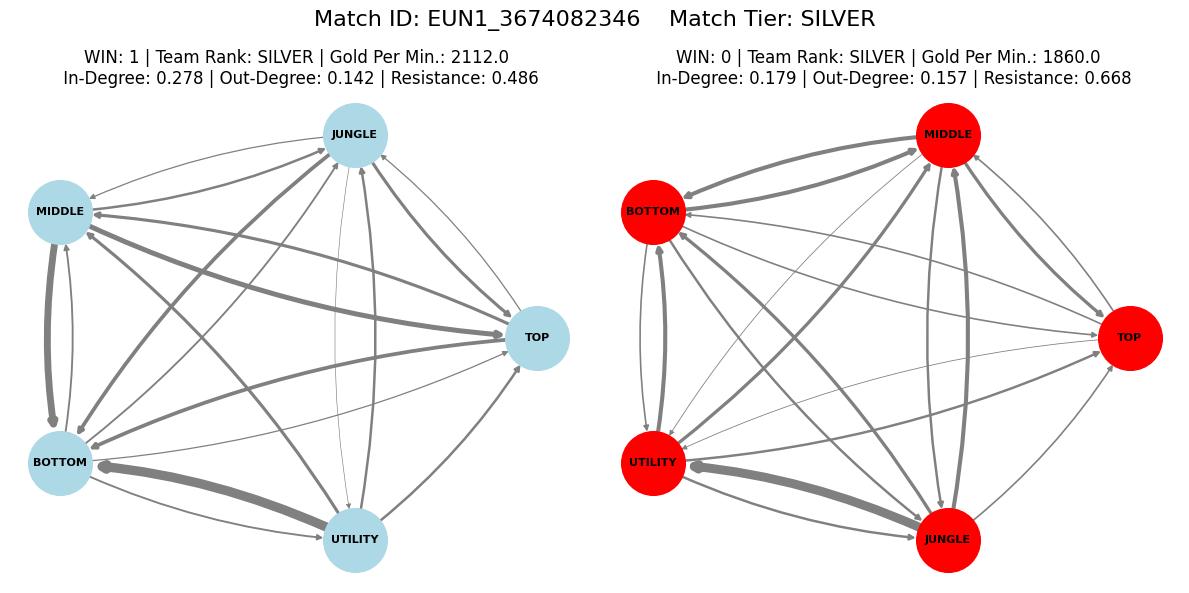

<Figure size 640x480 with 0 Axes>

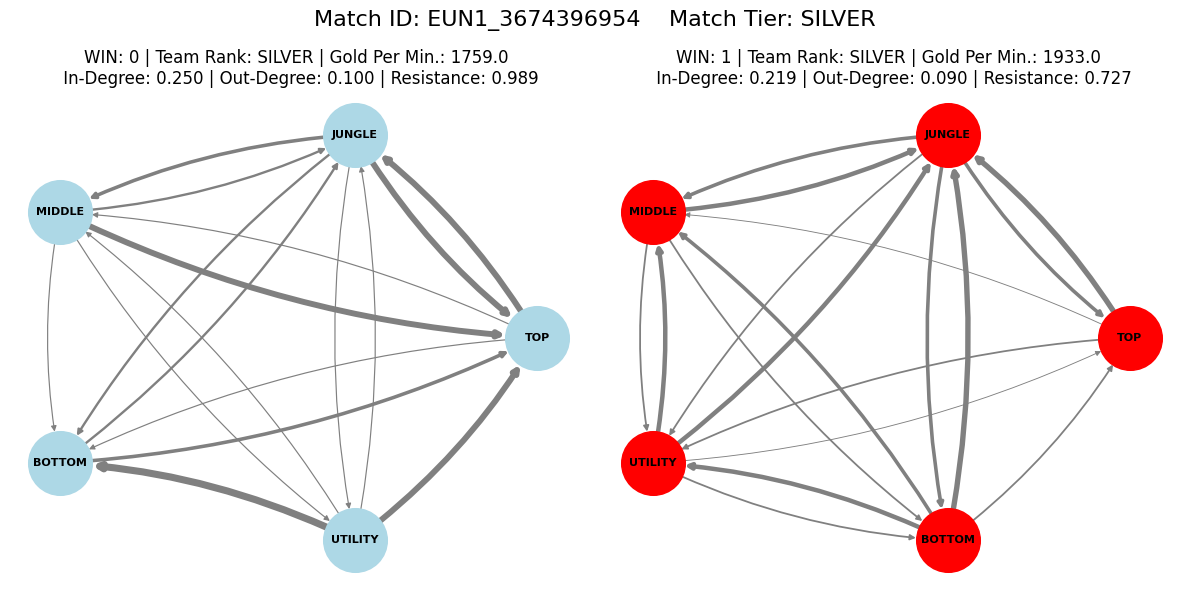

<Figure size 640x480 with 0 Axes>

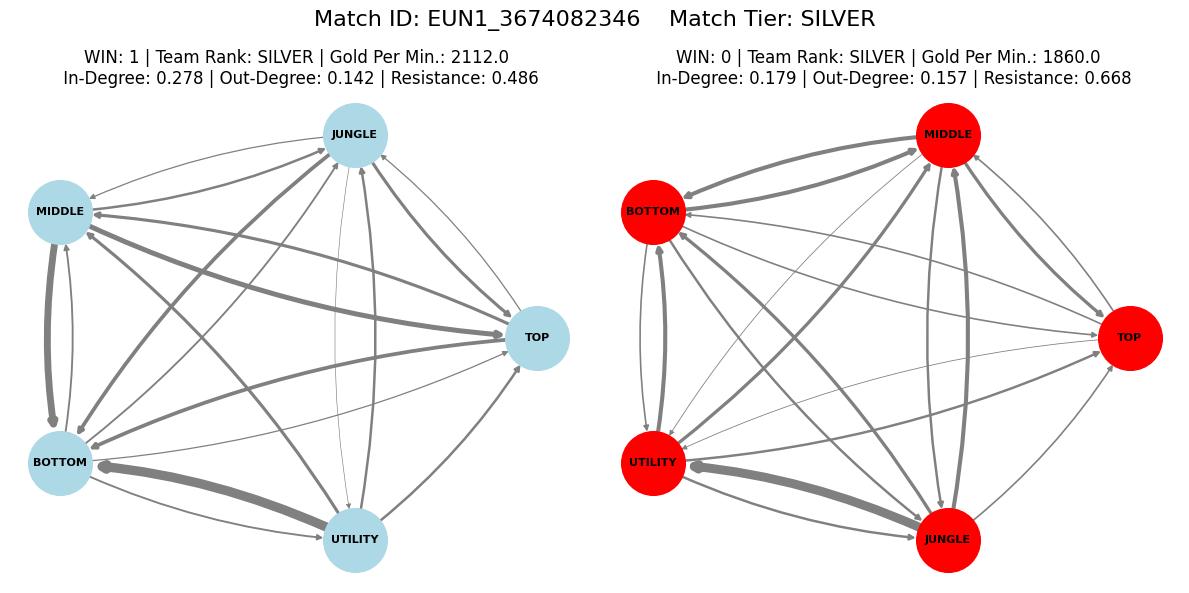

<Figure size 640x480 with 0 Axes>

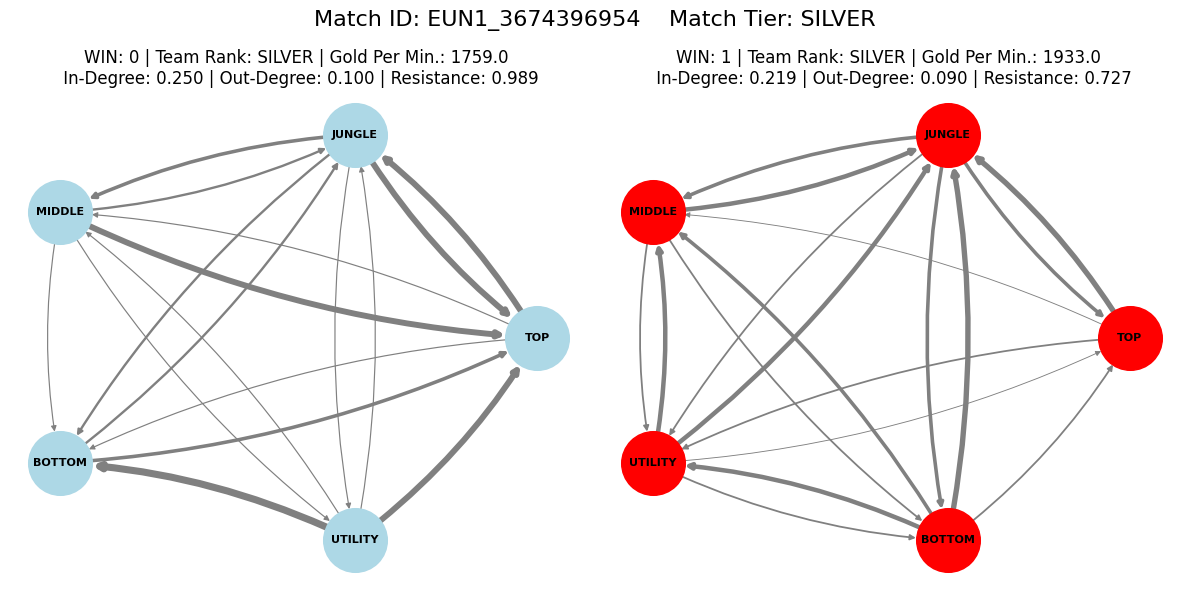

<Figure size 640x480 with 0 Axes>

In [31]:
gameIds = edgesDF['gameId'].tolist()
gameIds = list(set(gameIds))
gameIds = sorted(gameIds)

# these are 4 games that I handpicked after clustering of good and bad teams with majority good and bad and players
selectiveGameIds = ['EUN1_3674082346', 'EUN1_3674396954', 'EUN1_3674082346', 'EUN1_3674396954']
selectiveTeamIds = [100, 200, 200, 100]

# use incremental ranges of gameIds to save figure locally
for idx, gameId in enumerate(selectiveGameIds):
    # team level data of two teams in the same match-up
    blueTeamDF = edgesDF[(edgesDF['gameId'] == gameId) & (edgesDF['teamId'] == 100)]
    blueTeamDF = blueTeamDF[(blueTeamDF['toParticipantId'] >= 1) & (blueTeamDF['toParticipantId'] <= 5)] # additional filter to remove any steals or lease

    redTeamDF = edgesDF[(edgesDF['gameId'] == gameId) & (edgesDF['teamId'] == 200)]
    redTeamDF = redTeamDF[(redTeamDF['toParticipantId'] >= 6) & (redTeamDF['toParticipantId'] <= 10)] # additional filter to remove any steal or lease

    blueTeamEdges = [ (i*40) for i in blueTeamDF['normalizedWeight'] ]
    redTeamEdges = [ (i*40) for i in redTeamDF['normalizedWeight'] ]

    matchRank = blueTeamDF['gameRank'].iloc[0]
    titleText = f'Match ID: {gameId}    Match Tier: {matchRank}'

    blueTeamAvgRank = blueTeamDF['teamRank'].iloc[0]
    blueTeamWins = blueTeamDF['win'].iloc[0]
    blueTeamGPM = blueTeamDF['teamGPM'].iloc[0]
    blueTeamInD = blueTeamDF['teamIndegreeCentrality'].iloc[0]
    blueTeamOutD = blueTeamDF['teamOutdegreeCentrality'].iloc[0]
    blueTeamRes = blueTeamDF['resistance'].iloc[0]
    
    blueTeamText = f'WIN: {blueTeamWins} | Team Rank: {blueTeamAvgRank} | Gold Per Min.: {blueTeamGPM} \n In-Degree: {blueTeamInD:.3f} | Out-Degree: {blueTeamOutD:.3f} | Resistance: {blueTeamRes:.3f}'
    
    redTeamAvgRank = redTeamDF['teamRank'].iloc[0]
    redTeamWins = redTeamDF['win'].iloc[0]
    redTeamGPM = redTeamDF['teamGPM'].iloc[0]
    redTeamGPM = redTeamDF['teamGPM'].iloc[0]
    redTeamInD = redTeamDF['teamIndegreeCentrality'].iloc[0]
    redTeamOutD = redTeamDF['teamOutdegreeCentrality'].iloc[0]
    redTeamRes = redTeamDF['resistance'].iloc[0]

    redTeamText = f'WIN: {redTeamWins} | Team Rank: {redTeamAvgRank} | Gold Per Min.: {redTeamGPM} \n In-Degree: {redTeamInD:.3f} | Out-Degree: {redTeamOutD:.3f} | Resistance: {redTeamRes:.3f}'

    # create network graph objects
    BTG = nx.from_pandas_edgelist(blueTeamDF, source='fromPlayerPosition', target='toPlayerPosition', edge_attr='normalizedWeight', create_using=nx.MultiDiGraph(directed=True))
    RTG = nx.from_pandas_edgelist(redTeamDF, source='fromPlayerPosition', target='toPlayerPosition', edge_attr='normalizedWeight', create_using=nx.MultiDiGraph(directed=True))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    posB = nx.circular_layout(BTG)
    posR = nx.circular_layout(RTG)
    
    nx.draw(BTG, pos=posB, ax=axes[0], with_labels=True, node_size=2100, node_color="lightblue", font_size=8, connectionstyle='arc3,rad=0.1', font_weight="bold", arrowsize=8, width=blueTeamEdges, edge_color='gray')
    axes[0].set_title(blueTeamText)

    nx.draw(RTG, pos=posR, ax=axes[1], with_labels=True, node_size=2100, node_color="red", font_size=8, connectionstyle='arc3,rad=0.1', font_weight="bold", arrowsize=8, width=redTeamEdges, edge_color='gray')
    axes[1].set_title(redTeamText)

    # Match title
    plt.suptitle(titleText, fontsize=16)
    plt.tight_layout()
    plt.show()

    # save the figure
    # output_path = f'../graphs/{matchRank}/{gameId}.png'
    # plt.savefig(output_path, format='png', dpi=300)
    # print(f"Image {output_path} saved successfully")
    plt.clf()

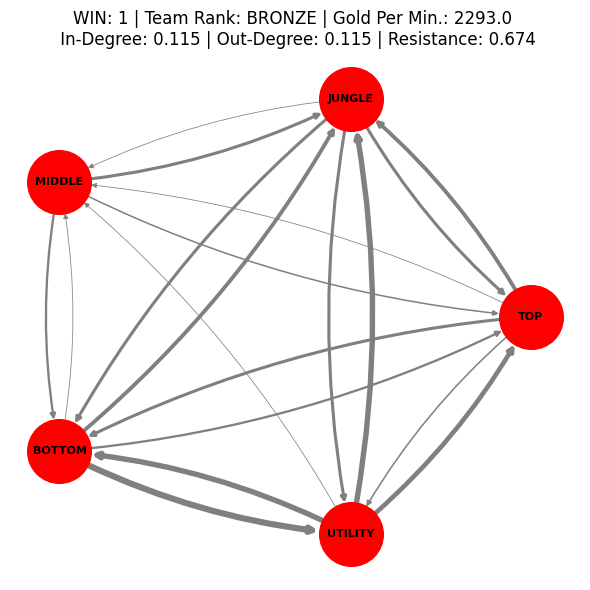

<Figure size 640x480 with 0 Axes>

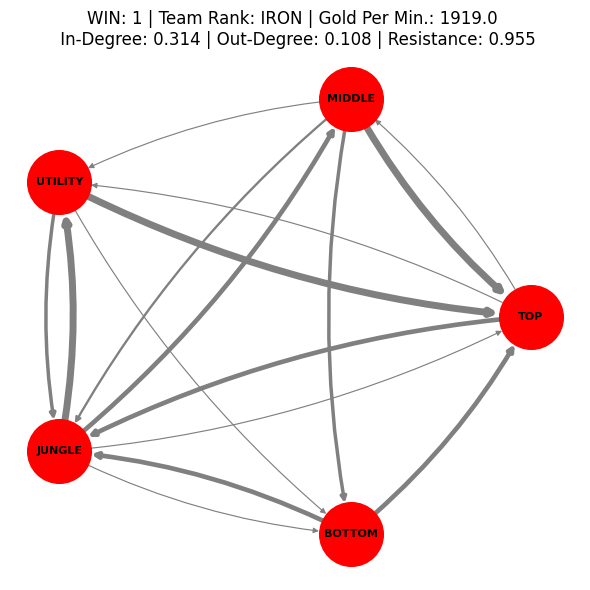

<Figure size 640x480 with 0 Axes>

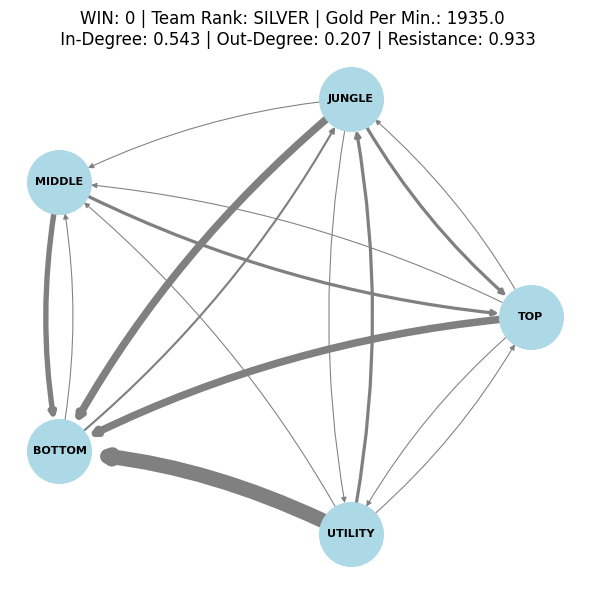

<Figure size 640x480 with 0 Axes>

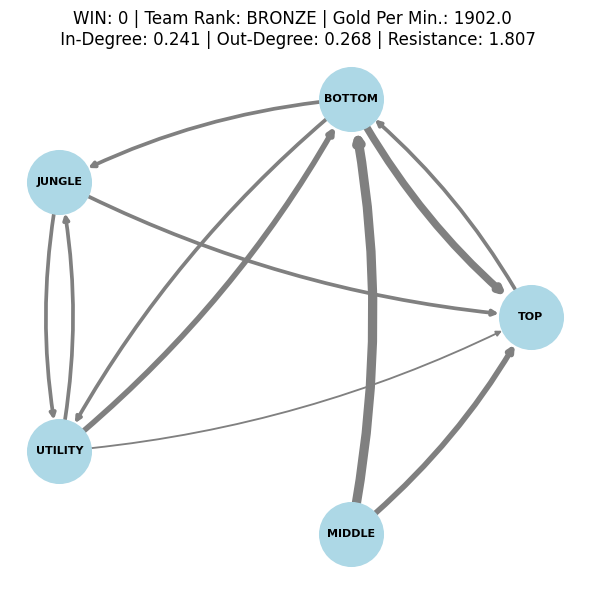

<Figure size 640x480 with 0 Axes>

In [38]:
### Selective selection of teams and matches

# Bad Players and Bad Team
# EUN1_3674432138 100 LOSS
# EUN1_3674859389 200
# TR1_1556136687 100
# TR1_1557328989 100 -> select

# Good player but bad team
# EUW1_6989460298 100 LOSS -> select
# EUN1_3675255343 100 LOSS
# ME1_4881433 100 LOSS
# ME1_4967396 100 -> select
# TR1_1557321820 200

# Good Players and Good Team
# EUN1_3674082346 100
# TR1_1557321820 100
# TR1_1557947149 200 -> select
# TR1_1558005152 200
# TR1_1557328989 200

# Bad Player but good team
# EUW1_7118184187 100
# EUW1_7130627224 200 -> select
# EUW1_7132696167 200
# EUW1_7143391223 100
# EUW1_7144046185 100


# these are 4 games that I handpicked after clustering of good and bad teams with majority good and bad and players
selectiveGameIds = ['TR1_1557947149', 'EUW1_7130627224', 'EUW1_6989460298', 'TR1_1557328989']
selectiveTeamIds = [200, 200, 100, 100, 100]

# use incremental ranges of gameIds to save figure locally
for idx, (teamId, gameId) in enumerate(zip(selectiveTeamIds, selectiveGameIds)):
    # team level data of two teams in the same match-up
    fig, axes = plt.subplots(figsize=(6, 6))
    if teamId == 100:
        blueTeamDF = edgesDF[(edgesDF['gameId'] == gameId) & (edgesDF['teamId'] == 100)]
        blueTeamDF = blueTeamDF[(blueTeamDF['toParticipantId'] >= 1) & (blueTeamDF['toParticipantId'] <= 5)] # additional filter to remove any steals or lease
        blueTeamEdges = [ (i*40) for i in blueTeamDF['normalizedWeight'] ]

        blueTeamAvgRank = blueTeamDF['teamRank'].iloc[0]
        blueTeamWins = blueTeamDF['win'].iloc[0]
        blueTeamGPM = blueTeamDF['teamGPM'].iloc[0]
        blueTeamInD = blueTeamDF['teamIndegreeCentrality'].iloc[0]
        blueTeamOutD = blueTeamDF['teamOutdegreeCentrality'].iloc[0]
        blueTeamRes = blueTeamDF['resistance'].iloc[0]
    
        blueTeamText = f'WIN: {blueTeamWins} | Team Rank: {blueTeamAvgRank} | Gold Per Min.: {blueTeamGPM} \n In-Degree: {blueTeamInD:.3f} | Out-Degree: {blueTeamOutD:.3f} | Resistance: {blueTeamRes:.3f}'
        matchRank = blueTeamDF['gameRank'].iloc[0]
        titleText = f'Match ID: {gameId}    Match Tier: {matchRank}'

        # create network graph objects
        BTG = nx.from_pandas_edgelist(blueTeamDF, source='fromPlayerPosition', target='toPlayerPosition', edge_attr='normalizedWeight', create_using=nx.MultiDiGraph(directed=True))
        posB = nx.circular_layout(BTG)

        nx.draw(BTG, pos=posB, ax=axes, with_labels=True, node_size=2100, node_color="lightblue", font_size=8, connectionstyle='arc3,rad=0.1', font_weight="bold", arrowsize=8, width=blueTeamEdges, edge_color='gray')
        axes.set_title(blueTeamText)
    
    else:
        redTeamDF = edgesDF[(edgesDF['gameId'] == gameId) & (edgesDF['teamId'] == 200)]
        redTeamDF = redTeamDF[(redTeamDF['toParticipantId'] >= 6) & (redTeamDF['toParticipantId'] <= 10)] # additional filter to remove any steal or lease
        redTeamEdges = [ (i*40) for i in redTeamDF['normalizedWeight'] ]

        redTeamAvgRank = redTeamDF['teamRank'].iloc[0]
        redTeamWins = redTeamDF['win'].iloc[0]
        redTeamGPM = redTeamDF['teamGPM'].iloc[0]
        redTeamGPM = redTeamDF['teamGPM'].iloc[0]
        redTeamInD = redTeamDF['teamIndegreeCentrality'].iloc[0]
        redTeamOutD = redTeamDF['teamOutdegreeCentrality'].iloc[0]
        redTeamRes = redTeamDF['resistance'].iloc[0]

        redTeamText = f'WIN: {redTeamWins} | Team Rank: {redTeamAvgRank} | Gold Per Min.: {redTeamGPM} \n In-Degree: {redTeamInD:.3f} | Out-Degree: {redTeamOutD:.3f} | Resistance: {redTeamRes:.3f}'
        matchRank = redTeamDF['gameRank'].iloc[0]
        titleText = f'Match ID: {gameId}    Match Tier: {matchRank}'
        
        # create network graph objects
        RTG = nx.from_pandas_edgelist(redTeamDF, source='fromPlayerPosition', target='toPlayerPosition', edge_attr='normalizedWeight', create_using=nx.MultiDiGraph(directed=True))
        posR = nx.circular_layout(RTG)

        nx.draw(RTG, pos=posR, ax=axes, with_labels=True, node_size=2100, node_color="red", font_size=8, connectionstyle='arc3,rad=0.1', font_weight="bold", arrowsize=8, width=redTeamEdges, edge_color='gray')
        axes.set_title(redTeamText)

    # Match title
    # plt.suptitle(titleText, fontsize=16)
    plt.tight_layout()
    plt.show()

    # save the figure
    # output_path = f'../graphs/{matchRank}/{gameId}.png'
    # plt.savefig(output_path, format='png', dpi=300)
    # print(f"Image {output_path} saved successfully")
    plt.clf()

In [ ]:
print(filtered_valid_player_match_details_df.shape)
print(filtered_valid_player_match_details_df.columns)

filtered_valid_player_match_details_df.head(20)

In [ ]:
# team averaged dataset
teamDF = filtered_valid_player_match_details_df[[
    'gameId', 'teamId', 'gameDuration', 'win', 'teamAverageRank', 'matchAverageRank', 
    'totalTeamKills', 'totalTeamDeaths', 'totalTeamAssists', 'totalTeamTurretKills', 'totalTeamEpicMonsterKills', 'totalTeamGold', 'totalTeamGPM', 
    'averageTeamChampExperience', 'averageTeamVisionScore', 'averageTeamMinionsKilled'
    ]]

assistsMapSubsetDF = assistsMapDF[['gameId', 'teamId', 'teamIndegreeCentrality', 'teamOutdegreeCentrality', 'totalTeamAllAssists', 'resistance']]
print(assistsMapSubsetDF.shape)
assistsMapSubsetDF.drop_duplicates(inplace=True)
print(assistsMapSubsetDF.shape)

teamDF = teamDF.merge(assistsMapSubsetDF, on=['gameId', 'teamId'], how='inner')
teamDF

In [ ]:
teamDF.drop_duplicates(inplace=True)
print(teamDF.shape)

In [28]:
teamDF.to_csv('../dataset/perMatchperTeamStats.csv', index=False)

In [29]:
assistsMapDF.to_csv('../dataset/assistsMap.csv', index=False)
filtered_valid_player_match_details_df.to_csv('../dataset/filteredMatchDetails.csv', index=False)